# **Diabeter Dataset**

**Data Story**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

* Pregnancies:Number of Pregnancy
* Glucose:2-hour plasma glucose concentration in the oral glucose tolerance test
* Blood Pressure:	Blood Pressure (Small Blood Pressure) (mmHg)
* SkinThicknessSkin:Thickness
* Insulin:2-hour serum insulin (mu U/ml)
* DiabetsPedigreeFunction:A function that calculates the probability of having diabetes according to one's descendants
* BMI: Body mass index
* Age: (Type: Year)
* Outcome:1 positive indicates does have diabetes, 0 indicates negative does not have diabetes.

In [310]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [311]:
df = pd.read_csv("diabetes.csv")

In [312]:
def data_review(dataframe):
    print("**********head**********")
    print(dataframe.head())
    print("**********isna**********")
    print(dataframe.isnull().sum())
    print("**********shape*********")
    print(dataframe.shape)
    print("*********info***********")
    print(dataframe.info())
    print("*********describe*******")
    print(dataframe.describe().T)
    print("*********nuniq*******")
    print(dataframe.nunique())

In [313]:
data_review(df)

**********head**********
   Pregnancies  Glucose  BloodPressure  ...  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72  ...                     0.627   50        1
1            1       85             66  ...                     0.351   31        0
2            8      183             64  ...                     0.672   32        1
3            1       89             66  ...                     0.167   21        0
4            0      137             40  ...                     2.288   33        1

[5 rows x 9 columns]
**********isna**********
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
**********shape*********
(768, 9)
*********info***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data colum

In [314]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [315]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [317]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [318]:
#Untuk mengubah semua data yang berangka 0, karena engga 0 pasti dia mati
columns_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in columns_with_zeros:
    df[col] = df[col].replace(0, np.NaN)

In [319]:
#Memeriksa kolom dengan missing values yang dimana tadinya dari angka 0 diubah menjadi NaN=Missing Values
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

EDA

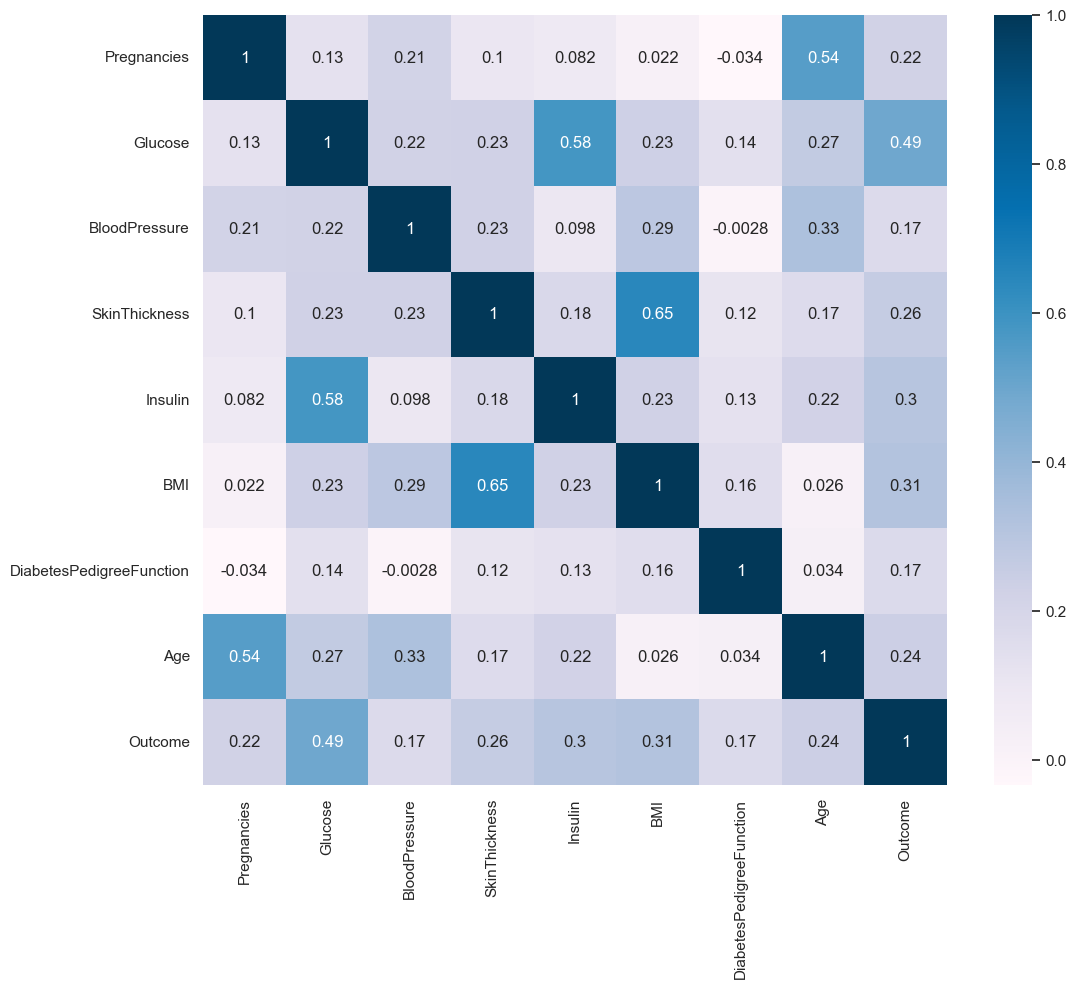

In [320]:
plt.figure(figsize=(12,10))  
p=sns.heatmap(df.corr(), annot=True,cmap =plt.cm.PuBu)

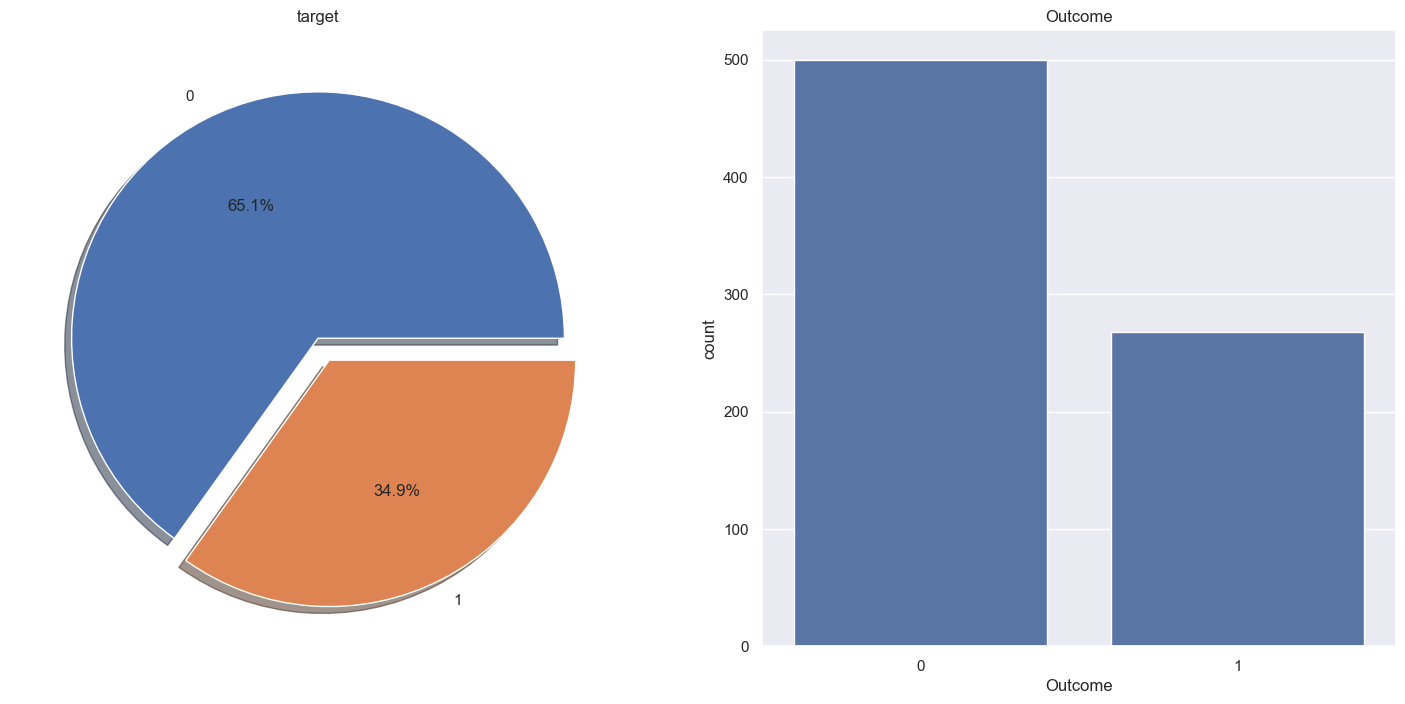

In [321]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Outcome'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot(x ='Outcome',data=df,ax=ax[1])
ax[1].set_title('Outcome')
plt.show()

In [322]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [323]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [324]:
#Memeriksa apakah ada outlier
check_outlier(df, "Insulin")

True

In [325]:
#function untuk mengatasi outlier yang melewati batas bawah dan batas atas
def handle_outliers(dataframe, column_list):
    for col in column_list:
        print(f"Processing: {col}")
        low_before, high_before = outlier_thresholds(dataframe, col)
        print(f" - Before replacement: lower = {low_before:.2f}, upper = {high_before:.2f}")

        replace_with_thresholds(dataframe, col)

        low_after, high_after = outlier_thresholds(dataframe, col)
        print(f" - After replacement:  lower = {low_after:.2f}, upper = {high_after:.2f}\n")


In [326]:
#Mengubah seluruh outlier dengan batas atas atau bawah dari data
columns_to_check = [
    "Insulin",
    "DiabetesPedigreeFunction",
    "SkinThickness",
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "BMI",
    "Age"
]

handle_outliers(df, columns_to_check)

Processing: Insulin
 - Before replacement: lower = -94.38, upper = 360.62
 - After replacement:  lower = -94.38, upper = 360.62

Processing: DiabetesPedigreeFunction
 - Before replacement: lower = -0.33, upper = 1.20
 - After replacement:  lower = -0.33, upper = 1.20

Processing: SkinThickness
 - Before replacement: lower = 1.00, upper = 57.00
 - After replacement:  lower = 1.00, upper = 57.00

Processing: Pregnancies
 - Before replacement: lower = -6.50, upper = 13.50
 - After replacement:  lower = -6.50, upper = 13.50

Processing: Glucose
 - Before replacement: lower = 36.00, upper = 204.00
 - After replacement:  lower = 36.00, upper = 204.00

Processing: BloodPressure
 - Before replacement: lower = 40.00, upper = 104.00
 - After replacement:  lower = 40.00, upper = 104.00

Processing: BMI
 - Before replacement: lower = 13.85, upper = 50.25
 - After replacement:  lower = 13.85, upper = 50.25

Processing: Age
 - Before replacement: lower = -1.50, upper = 66.50
 - After replacement:  l

C:\Users\Clive\AppData\Local\Temp\ipykernel_20464\1428178594.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\Clive\AppData\Local\Temp\ipykernel_20464\1428178594.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


Data Cleaning and Preprocessing

In [327]:
#Memeriksa kolom yang kosong
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

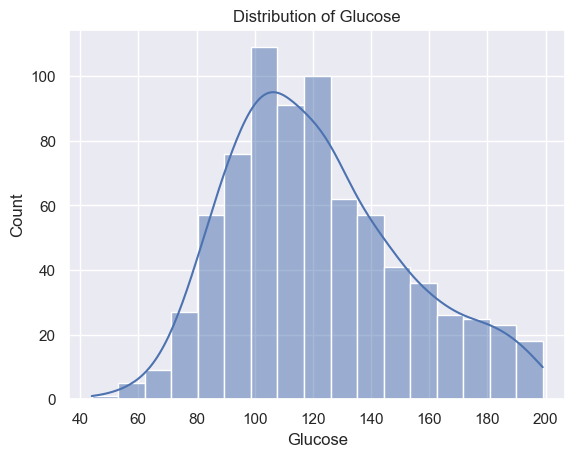

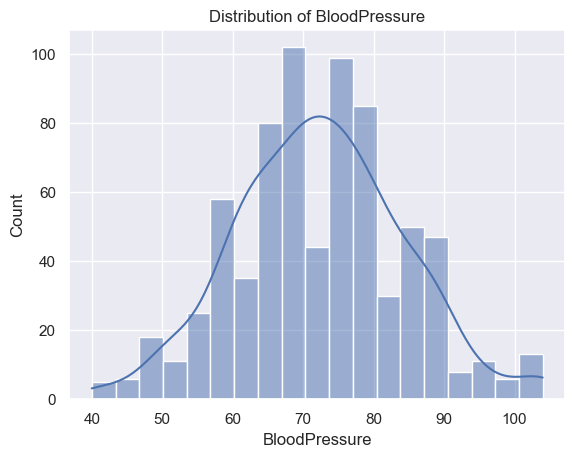

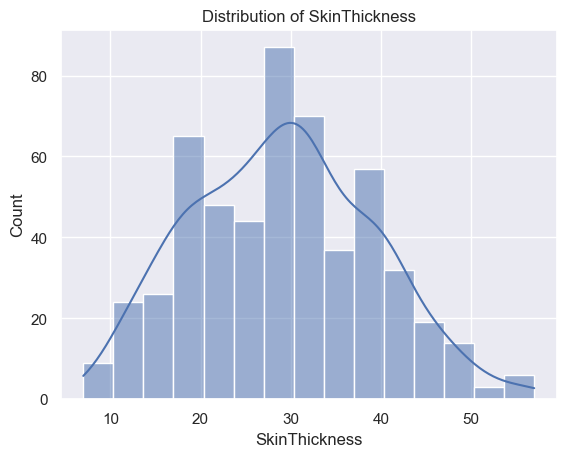

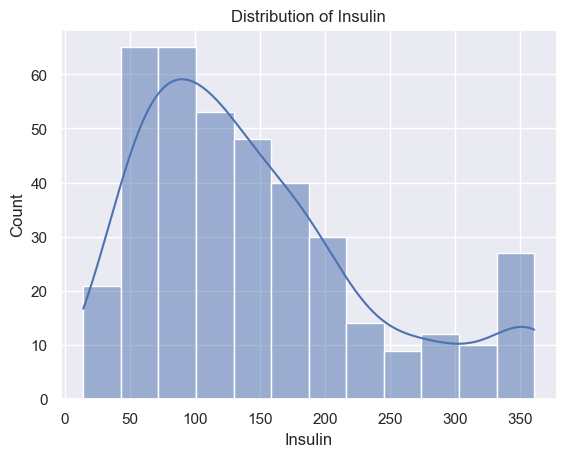

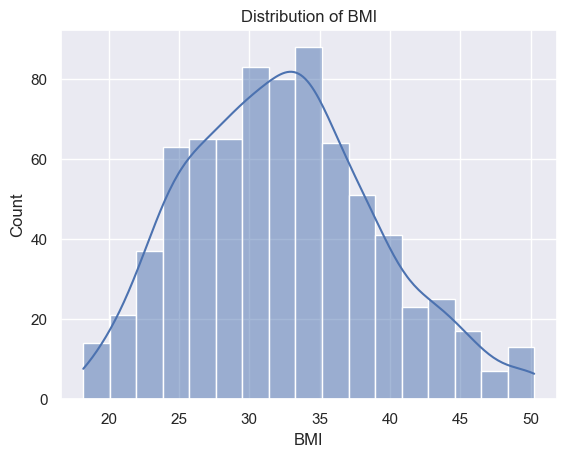

In [328]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_with_na = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in cols_with_na:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [329]:
#Memeriksa persentase missing value dari kolom yang memiliki missing values tetapi tidak melebihi 50%

col_miss_per = df.isnull().mean() * 100
col_miss_per = col_miss_per.sort_values(ascending=False)

print("Missing Values Percentage of each column:\n")

for col,per in col_miss_per.items():
    if per > 0:
        if per >= 50:
            df = df.drop(col, axis=1)
        else:
            print(f"{col}: {per:.2f}%")
            df[col] = df[col].fillna(df[col].median())

Missing Values Percentage of each column:

Insulin: 48.70%
SkinThickness: 29.56%
BloodPressure: 4.56%
BMI: 1.43%
Glucose: 0.65%


In [330]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

EDA Part 2

In [331]:
df.dtypes

Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Outcome                       int64
dtype: object

In [332]:
#Memeriksa persentase risiko diabetes berdasarkan umur
for col in df.columns:
    if col != 'Outcome':
        print()
        print(df.groupby(col)["Outcome"].mean())


Pregnancies
0.0     0.342342
1.0     0.214815
2.0     0.184466
3.0     0.360000
4.0     0.338235
5.0     0.368421
6.0     0.320000
7.0     0.555556
8.0     0.578947
9.0     0.642857
10.0    0.416667
11.0    0.636364
12.0    0.444444
13.0    0.500000
13.5    1.000000
Name: Outcome, dtype: float64

Glucose
44.0     0.00
56.0     0.00
57.0     0.00
61.0     0.00
62.0     0.00
         ... 
195.0    1.00
196.0    1.00
197.0    0.75
198.0    1.00
199.0    1.00
Name: Outcome, Length: 135, dtype: float64

BloodPressure
40.0     0.400000
44.0     0.000000
46.0     0.000000
48.0     0.200000
50.0     0.384615
52.0     0.272727
54.0     0.181818
55.0     0.000000
56.0     0.083333
58.0     0.095238
60.0     0.189189
61.0     0.000000
62.0     0.294118
64.0     0.302326
65.0     0.142857
66.0     0.366667
68.0     0.266667
70.0     0.403509
72.0     0.405063
74.0     0.326923
75.0     0.125000
76.0     0.461538
78.0     0.377778
80.0     0.325000
82.0     0.433333
84.0     0.521739
85.0     0.50

In [333]:
df.loc[(df['BMI'] < 18.5) , 'WeightCategory'] = 'Underweight'
df.loc[(df['BMI'] >= 18.5) & (df['BMI'] <= 24.9 ), 'WeightCategory'] = 'Normal'
df.loc[(df['BMI'] >= 25) & (df['BMI'] <= 29.9 ), 'WeightCategory'] = 'Overweight'
df.loc[(df['BMI'] >= 30) & (df['BMI'] <= 34.9 ), 'WeightCategory'] = 'Obese'
df.loc[(df['BMI'] >= 35) , 'WeightCategory'] = 'ExtObese'

In [334]:
def state_Ins(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    elif row["Insulin"] >= 167 and row["Insulin"] <=200:
        return "Prediabet"
    else:
        return "Abnormal"

In [335]:
df = df.assign(InsulinLevel=df.apply(state_Ins, axis=1))

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,WeightCategory,InsulinLevel
0,6.0,148.0,72.0,35.0,125.0,33.6,0.627,50.0,1,Obese,Normal
1,1.0,85.0,66.0,29.0,125.0,26.6,0.351,31.0,0,Overweight,Normal
2,8.0,183.0,64.0,29.0,125.0,23.3,0.672,32.0,1,Normal,Normal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight,Normal
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,ExtObese,Prediabet


In [336]:
# Menentukan rata-rata nilai pedigree function (nilsi keturunan) dari pengidap dan non-pegindap diabetes
df.groupby("Outcome")["DiabetesPedigreeFunction"].mean()

Outcome
0    0.420264
1    0.531022
Name: DiabetesPedigreeFunction, dtype: float64

In [337]:
#Melihat rata-rata glukosa dari setiap Weight Category
df.groupby("WeightCategory")["Glucose"].mean()

WeightCategory
ExtObese       128.447581
Normal         109.127451
Obese          123.923404
Overweight     117.000000
Underweight     95.250000
Name: Glucose, dtype: float64

**Encoding Operations**

In [338]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [339]:
ohe_cols


['WeightCategory', 'InsulinLevel']

In [340]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [341]:
df = one_hot_encoder(df,ohe_cols)

In [342]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,WeightCategory_Normal,WeightCategory_Obese,WeightCategory_Overweight,WeightCategory_Underweight,InsulinLevel_Normal,InsulinLevel_Prediabet
0,6.0,148.0,72.0,35.0,125.0,33.6,0.627,50.0,1,False,True,False,False,True,False
1,1.0,85.0,66.0,29.0,125.0,26.6,0.351,31.0,0,False,False,True,False,True,False
2,8.0,183.0,64.0,29.0,125.0,23.3,0.672,32.0,1,True,False,False,False,True,False
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,False,False,True,False,True,False
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,False,False,False,False,False,True


**Standardization**

In [343]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [344]:
num_cols = [col for col in df.columns if df[col].dtypes in ['int64', 'float64']]
num_cols.remove("Outcome")

In [345]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [346]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,WeightCategory_Normal,WeightCategory_Obese,WeightCategory_Overweight,WeightCategory_Underweight,InsulinLevel_Normal,InsulinLevel_Prediabet
0,6.0,148.0,72.0,35.0,125.0,33.6,0.627,50.0,1,False,True,False,False,True,False
1,1.0,85.0,66.0,29.0,125.0,26.6,0.351,31.0,0,False,False,True,False,True,False
2,8.0,183.0,64.0,29.0,125.0,23.3,0.672,32.0,1,True,False,False,False,True,False
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,False,False,True,False,True,False
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,False,False,False,False,False,True


**Random Forest Model**

In [347]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [348]:
rf_model = RandomForestClassifier(random_state=42)

In [349]:
#Parameter tuning for Random Forest Model
rf_parameter_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_parameter_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

print(f"Best RF Params: {rf_grid_search.best_params_}")
rf_model = rf_grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best RF Params: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [350]:
rf_pred = rf_model.predict(X_test)

In [351]:
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy Score: ", rf_accuracy)
rf_recall = recall_score(y_test, rf_pred)
print("Recall Score: ", rf_recall)
rf_precision = precision_score(y_test, rf_pred)
print("Precision Score: ", rf_precision)
rf_roc = roc_auc_score(y_test, rf_pred)
print("ROC AUC Score: ", rf_roc)


Accuracy Score:  0.7922077922077922
Recall Score:  0.7037037037037037
Precision Score:  0.7037037037037037
ROC AUC Score:  0.7718518518518518


In [352]:
cm = confusion_matrix(y_test, rf_pred)
cm

array([[126,  24],
       [ 24,  57]], dtype=int64)

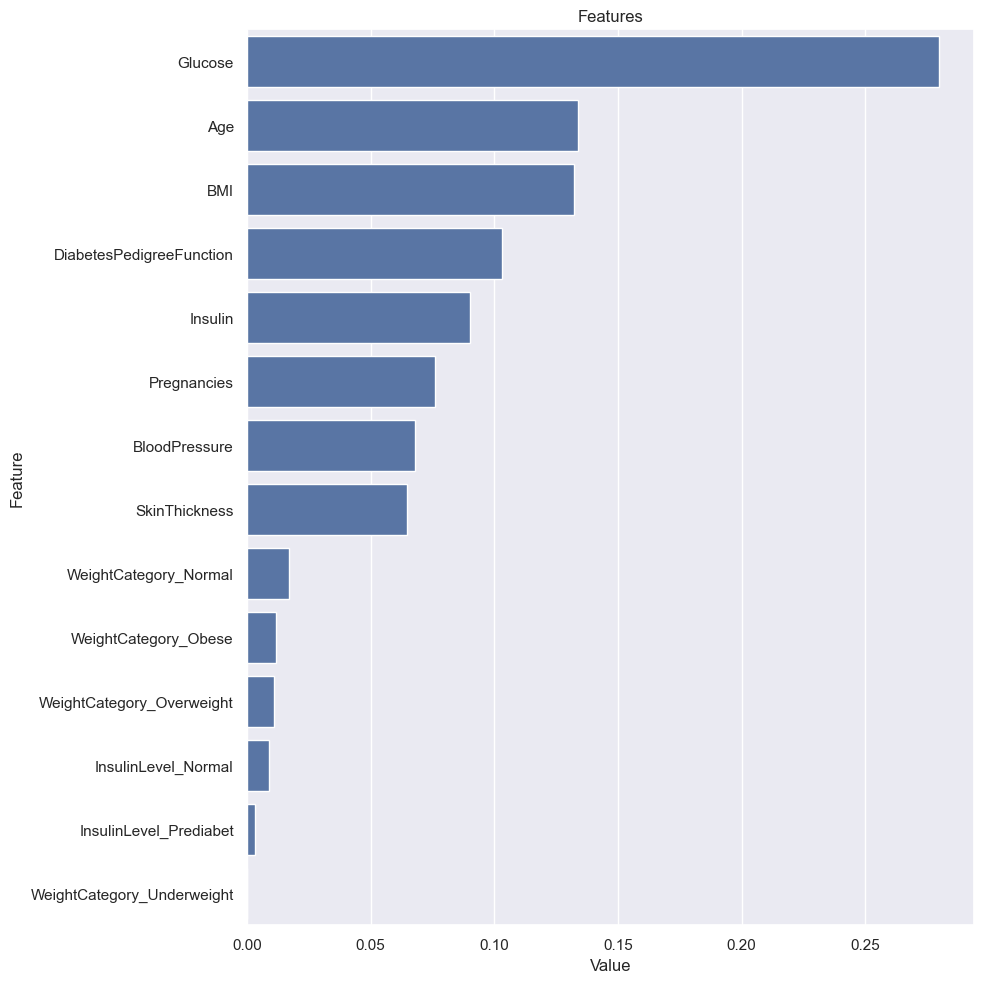

In [353]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

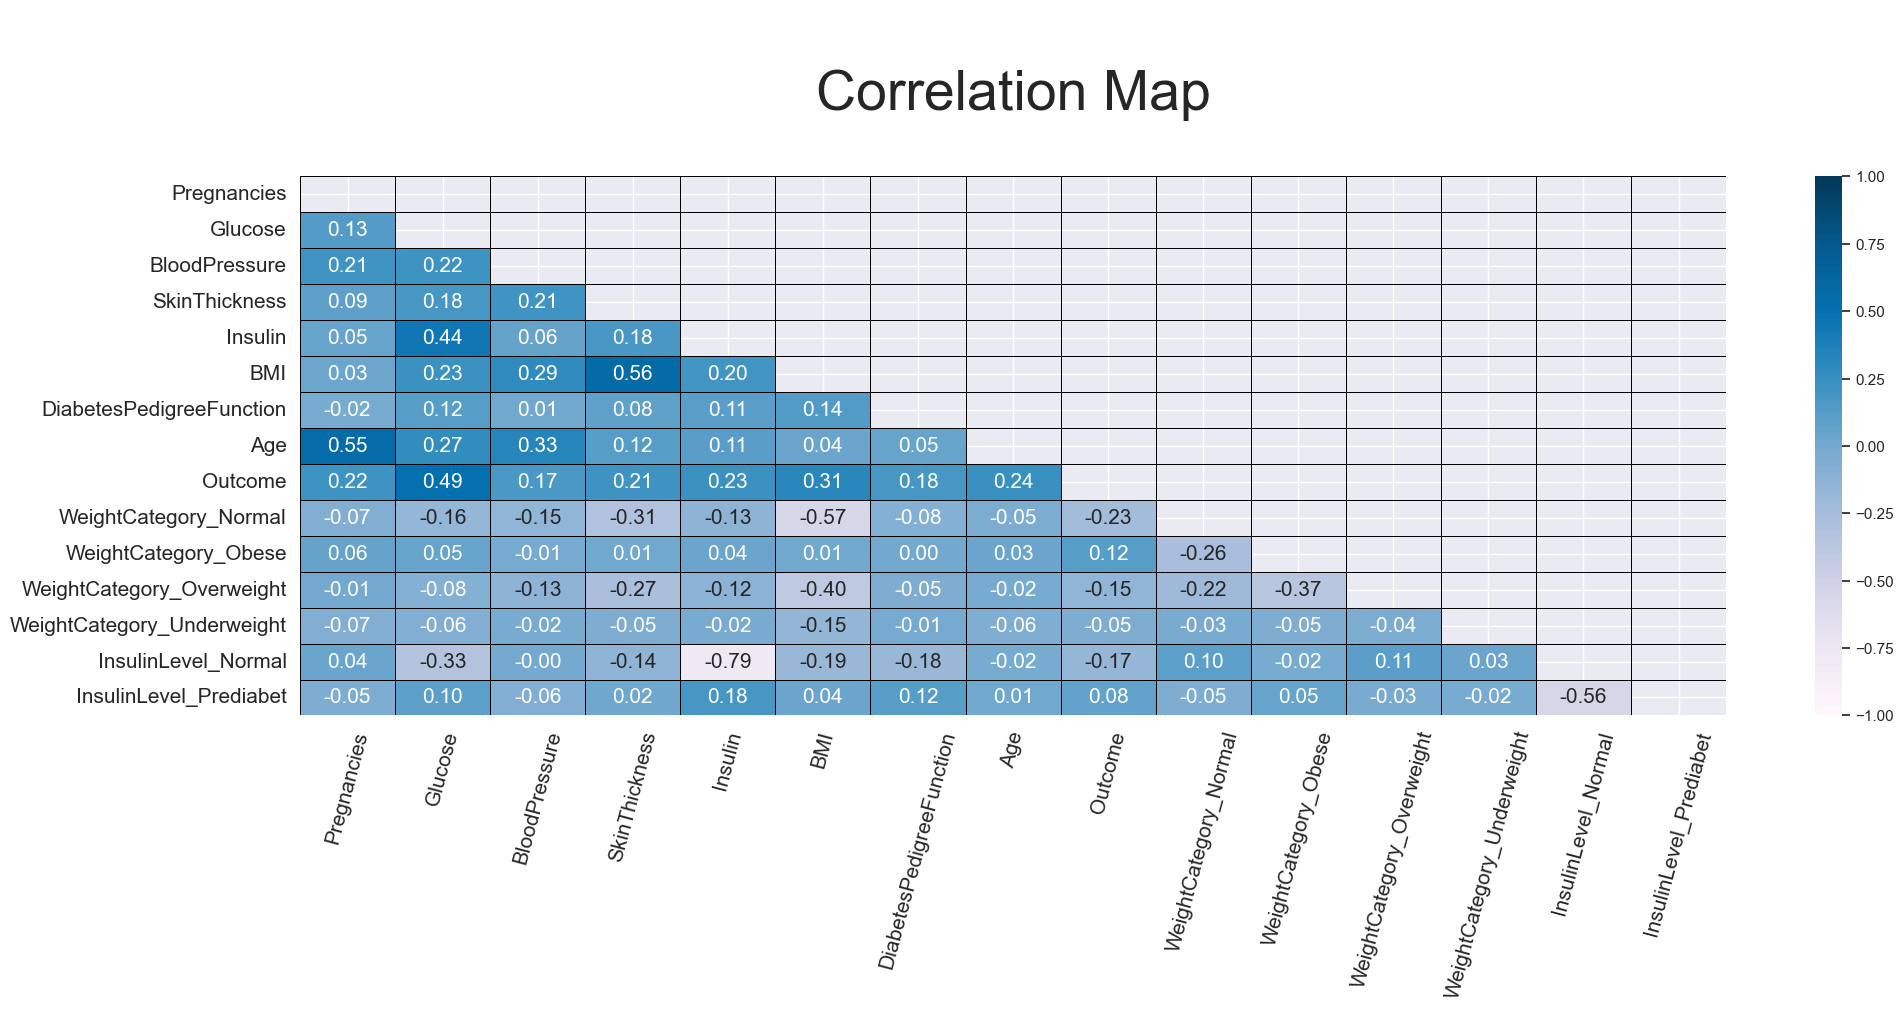

In [354]:
def corr_map(df):
    mtx = np.triu(df.corr())
    f,ax=plt.subplots(figsize = (23,7))
    sns.heatmap(df.corr(),
                annot= True,
                fmt = ".2f",
                ax=ax,
                vmin = -1,
                vmax = 1,
                cmap = "PuBu",
                mask = mtx,
                linewidth = 0.4,
                linecolor = "black",
                annot_kws={"size": 15})
    plt.yticks(rotation=0,size=15)
    plt.xticks(rotation=75,size=15)
    plt.title('\nCorrelation Map\n', size = 40)
    plt.show()
    
corr_map(df)

**Logistic Regression**

In [355]:
from sklearn.linear_model import LogisticRegression

In [356]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)

In [357]:
lr_parameter_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'l1_ratio': [0.5]
}

In [358]:
lr_grid_search = GridSearchCV(estimator=lr_model, param_grid=lr_parameter_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
lr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\_logistic.py", line 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.5],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [359]:
print(f"Best Parameters for Logistic Regression: {lr_grid_search.best_params_}")
print(f"Best Cross-Validation Score: {lr_grid_search.best_score_:.4f}")

Best Parameters for Logistic Regression: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Score: 0.7692


In [360]:
lr_model = lr_grid_search.best_estimator_

In [361]:
lr_pred = lr_model.predict(X_test)

In [362]:
cm = confusion_matrix(y_test, lr_pred)
cm

array([[131,  19],
       [ 31,  50]], dtype=int64)

In [363]:
lr_accuracy = accuracy_score(y_test, lr_pred)
print("Accuracy Score: ", lr_accuracy)
lr_recall = recall_score(y_test, lr_pred)
print("Recall Score: ", lr_recall)
lr_precision = precision_score(y_test, lr_pred)
print("Precision Score: ", lr_precision)
lr_roc = roc_auc_score(y_test, lr_pred)
print("ROC AUC Score: ", lr_roc)


Accuracy Score:  0.7835497835497836
Recall Score:  0.6172839506172839
Precision Score:  0.7246376811594203
ROC AUC Score:  0.7453086419753087


XGBoost

In [364]:
import xgboost as xgb

In [365]:
xgb_parameter_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [395]:
xgb_model = xgb.XGBClassifier(booster = 'gbtree', random_state=42, use_label_encoder=False, eval_metric='logloss')

In [396]:
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_parameter_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

In [397]:
xgb_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\xgboost\training.py:183: UserWarning: [16:41:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constr...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [398]:
print(f"Best Parameters for XGBoost: {xgb_grid_search.best_params_}")
print(f"Best Cross-Validation Score: {xgb_grid_search.best_score_:.2f}")

Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Best Cross-Validation Score: 0.78


In [399]:
xgb_model = xgb_grid_search.best_estimator_

In [400]:
xgb_pred = xgb_model.predict(X_test)

In [401]:
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print("Accuracy Score: ", xgb_accuracy)
xgb_recall = recall_score(y_test, xgb_pred)
print("Recall Score: ", xgb_recall)
xgb_precision = precision_score(y_test, xgb_pred)
print("Precision Score: ", xgb_precision)
xgb_roc = roc_auc_score(y_test, xgb_pred)
print("ROC AUC Score: ", xgb_roc)

Accuracy Score:  0.7922077922077922
Recall Score:  0.6790123456790124
Precision Score:  0.7142857142857143
ROC AUC Score:  0.7661728395061728


In [402]:
cm = confusion_matrix(y_test, xgb_pred)
cm

array([[128,  22],
       [ 26,  55]], dtype=int64)

Support Vector Classifier

In [374]:
from sklearn.svm import SVC

In [375]:
svc_model = SVC(kernel='linear', random_state=0, probability=True)

In [376]:
svc_parameter_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'gamma': [0.1, 0.5, 1, 5, 10],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

svc_grid_search = GridSearchCV(estimator=svc_model, param_grid=svc_parameter_grid, cv=5, verbose=2)
svc_grid_search.fit(X, y)

svc_model = svc_grid_search.best_estimator_ 

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.1, k

In [377]:
svc_cv_score = cross_validate(svc_model, X, y, cv=5)
print(svc_cv_score['test_score'].mean())

0.7682454800101859


In [378]:
print(svc_grid_search.best_params_)

{'C': 5, 'gamma': 0.1, 'kernel': 'linear'}


In [379]:
svc_model = SVC(kernel='rbf', probability=True, random_state=0)

svc_parameter_grid = {
    'C': [1, 2, 3],
    'gamma': [0.25, 0.5, 0.75]
}

svc_grid_search = GridSearchCV(estimator=svc_model, param_grid=svc_parameter_grid, cv=5, verbose=2)
svc_grid_search.fit(X_train, y_train)

svc_model = svc_grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ....................................C=1, gamma=0.25; total time=   0.0s
[CV] END ....................................C=1, gamma=0.25; total time=   0.0s
[CV] END ....................................C=1, gamma=0.25; total time=   0.0s
[CV] END ....................................C=1, gamma=0.25; total time=   0.0s
[CV] END ....................................C=1, gamma=0.25; total time=   0.0s
[CV] END .....................................C=1, gamma=0.5; total time=   0.0s
[CV] END .....................................C=1, gamma=0.5; total time=   0.0s
[CV] END .....................................C=1, gamma=0.5; total time=   0.0s
[CV] END .....................................C=1, gamma=0.5; total time=   0.0s
[CV] END .....................................C=1, gamma=0.5; total time=   0.0s
[CV] END ....................................C=1, gamma=0.75; total time=   0.0s
[CV] END ....................................C=1,

In [380]:
print(svc_grid_search.best_params_)

{'C': 1, 'gamma': 0.25}


In [381]:
svc_cv_score = cross_validate(svc_model, X, y, cv=5)
print(svc_cv_score['test_score'].mean())

0.6510482981071216


In [382]:
svc_pred = svc_model.predict(X_test)

In [383]:
svc_accuracy = accuracy_score(y_test, svc_pred)
print("Accuracy Score: ", svc_accuracy)
svc_recall = recall_score(y_test, svc_pred)
print("Recall Score: ", svc_recall)
svc_precision = precision_score(y_test, svc_pred)
print("Precision Score: ", svc_precision)
svc_roc = roc_auc_score(y_test, svc_pred)
print("ROC AUC Score: ", svc_roc)

Accuracy Score:  0.7748917748917749
Recall Score:  0.5925925925925926
Precision Score:  0.7164179104477612
ROC AUC Score:  0.7329629629629629


In [384]:
cm = confusion_matrix(y_test, svc_pred)
cm

array([[131,  19],
       [ 33,  48]], dtype=int64)

KNN

In [408]:
from sklearn.neighbors import KNeighborsClassifier

In [409]:
#Tuning KNN Model with GridSearchCV
knn_parameter_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_model = KNeighborsClassifier()
knn_grid_search= GridSearchCV(estimator=knn_model, param_grid=knn_parameter_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

In [410]:
knn_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [411]:
knn_model = knn_grid_search.best_estimator_
print(f"Best parameter for KNN: {knn_grid_search.best_params_}")

Best parameter for KNN: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}


In [412]:
knn_pred = knn_model.predict(X_test)

In [413]:
knn_accuracy = accuracy_score(y_test, knn_pred)
print("Accuracy Score: ", knn_accuracy)
knn_recall = recall_score(y_test, knn_pred)
print("Recall Score: ", knn_recall)
knn_precision = precision_score(y_test, knn_pred)
print("Precision Score: ", knn_precision)
knn_roc = roc_auc_score(y_test, knn_pred)
print("ROC AUC Score: ", knn_roc)

Accuracy Score:  0.7662337662337663
Recall Score:  0.5432098765432098
Precision Score:  0.7213114754098361
ROC AUC Score:  0.7149382716049384


In [414]:
cm = confusion_matrix(y_test, knn_pred)
cm

array([[133,  17],
       [ 37,  44]], dtype=int64)

Ensemble Training: Stacking

In [415]:
from sklearn.ensemble import StackingClassifier

In [ ]:
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model), 
    ('svc', svc_model),
    ('knn', knn_model)  
]

In [ ]:
meta_model = LogisticRegression()


In [417]:
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5
)

In [418]:
stack_model.fit(X_train, y_train)
stack_pred = stack_model.predict(X_test)
stack_accuracy = accuracy_score(y_test, stack_pred)
print(f"Scikit-learn Stacking Model Accuracy: {stack_accuracy}")
print(classification_report(y_test, stack_pred))

c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\xgboost\training.py:183: UserWarning: [16:52:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Clive\anaconda3\envs\deep_l

Scikit-learn Stacking Model Accuracy: 0.7619047619047619
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       150
           1       0.70      0.56      0.62        81

    accuracy                           0.76       231
   macro avg       0.74      0.71      0.72       231
weighted avg       0.76      0.76      0.75       231



c:\Users\Clive\anaconda3\envs\deep_learning\lib\site-packages\xgboost\training.py:183: UserWarning: [16:52:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "subsample", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [419]:
cm = confusion_matrix(y_test, stack_pred)
cm

array([[131,  19],
       [ 36,  45]], dtype=int64)

In [420]:
print(classification_report(y_test, stack_pred))


              precision    recall  f1-score   support

           0       0.78      0.87      0.83       150
           1       0.70      0.56      0.62        81

    accuracy                           0.76       231
   macro avg       0.74      0.71      0.72       231
weighted avg       0.76      0.76      0.75       231



In [ ]:
models = ['Random Forest', 'Logistic Regression', 'XGBoost', 'SVC', 'KNN', 'Meta Model']
scores = [rf_accuracy,lr_accuracy,xgb_accuracy,svc_accuracy,knn_accuracy, stack_accuracy]

models = pd.DataFrame({'Model' : models, 'Score' : scores})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
0,Random Forest,0.792208
2,XGBoost,0.792208
1,Logistic Regression,0.783550
3,SVC,0.774892
4,KNN,0.766234
5,Meta Model,0.761905


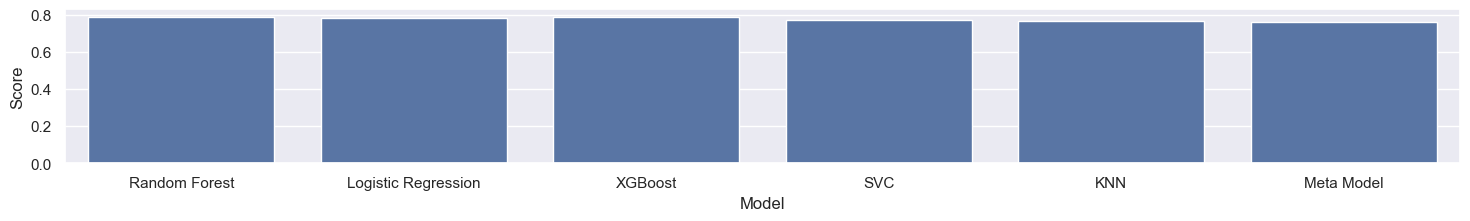

In [423]:
plt.figure(figsize = (18, 2))

sns.barplot(x = 'Model', y = 'Score', data = models)
plt.show()


In [394]:
import joblib

joblib.dump(xgb_model, 'diabetes_model.pkl')

['diabetes_model.pkl']